In [1]:
from src.containers.evaluation_container import EvaluationContainer
from src.services.config.config_interface import DirConfig

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')
eval_dir_config = DirConfig('local', 'eval001', False)

In [16]:
results = []
for exp in [
    'optimize001', 'optimize002', 
    'optimize003', 'optimize004', 
    'optimize005', 'optimize006', 
    'optimize007', 'optimize008'
    ]:
    container = EvaluationContainer(exp, debug=False)
    name = container.config.base_config.name
    container.initialize()
    base_config = container.config.base_config
    config = container.config
    postprocess_config = config.postprocess_config

    n_sample = min(container.test_df.shape[0], postprocess_config.n_sample)
    random_checked = set()
    # self.assignments.append([name, seed, budget_constraint, assignment])
    for seed, budget_constraint, assginment in container.assignments:
        # test_dfからランダムにn_sample個のidxを取得
        sample_idx = container.test_df.sample(n_sample, random_state=seed).index.to_numpy()
        # sample_idxのデータを取得しsample_dfに格納
        sample_df = container.test_df.loc[sample_idx].copy().reset_index(drop=True)
        # target列にGMVを代入
        sample_df['target'] = sample_df[base_config.target_name]
        # sample_dfのなかで各config.treatment_nameの数をカウント
        n_treatment = sample_df[base_config.treatment_name].value_counts().to_dict()
        n_treatment_all = sum(n_treatment.values())
        # cost列にvariant_no_to_costの値を代入
        sample_df['cost'] = sample_df[base_config.treatment_name].map(postprocess_config.variant_no_to_cost)
        # random
        if (seed,budget_constraint) not in random_checked:
            # cost列の累積和がbudget_constraintを超えるidxを取得 frac=1は100%とってきてシャッフル
            # assign_indexはあとで0にするindex
            assgin_index = (sample_df.sample(frac=1)['cost'].cumsum() > budget_constraint).sort_index()
            # assginment列に0~6の乱数を代入 -> 1~6では？ 
            sample_df['assginment'] = np.random.randint(0, 7, len(sample_df))
            # assgin_indexのidxに0を上書き
            sample_df.loc[assgin_index, 'assginment'] = 0
            # upliftgmv
            random_gmv = 0
            cost = 0
            for t in range(1, 7):
                random_gmv += sample_df['target'][(sample_df['assginment']==t) & (sample_df[base_config.treatment_name]==t)].sum()*(n_treatment_all/n_treatment[t])
                random_gmv -= sample_df['target'][(sample_df['assginment']==t) & (sample_df[base_config.treatment_name]!=t)].sum()*(n_treatment_all/(1-n_treatment[t]))
                cost += sample_df['cost'][(sample_df['assginment']==t)& (sample_df[base_config.treatment_name]==t)].sum()
                #cost -= sample_df['cost'][(sample_df['assginment']==t) & (sample_df[config.treatment_name]!=t)].sum()*(n_treatment_all/(1-n_treatment[t]))
            # 一致しているものの割合 -> つかってない
            # 実際のconfig.treatment_nameとassginmentが一致していないものを集計
            random_rate = (sample_df['target'][(assginment==sample_df[base_config.treatment_name])]!=0).mean()
            results.append(['random', seed, budget_constraint, random_gmv, random_rate])   
            random_checked.add((seed,budget_constraint))
            
        # model
        gmv = 0
        cost = 0
        for t in range(1, 7):
            gmv += sample_df['target'][(assginment==t) & (sample_df[base_config.treatment_name]==t)].sum()*(n_treatment_all/n_treatment[t])
            gmv -= sample_df['target'][(assginment==t) & (sample_df[base_config.treatment_name]!=t)].sum()*(n_treatment_all/(1-n_treatment[t]))
            cost += sample_df['cost'][(assginment==t) & (sample_df[base_config.treatment_name]==t)].sum()
            # cost -= sample_df['cost'][(assginment==t) & (sample_df[config.treatment_name]!=t)].sum()*(n_treatment_all/(1-n_treatment[t]))
        rate = (sample_df['target'][(assginment==sample_df[base_config.treatment_name])]!=0).mean()
        results.append([name, seed, budget_constraint, gmv, rate])

result_df = pd.DataFrame(results, columns=['name', 'seed', 'budget_constraint', 'GMV', 'assign_rate'])
result_df['budget_constraint'] = result_df['budget_constraint'].astype(int)
result_df = result_df.drop_duplicates().reset_index(drop=True)
result_df['random'] = result_df['name'] == 'random'
result_df = result_df.sort_values(['random', 'name','budget_constraint','seed'])
result_df[['metalearner', 'optimization']] = result_df['name'].str.split(', ', expand=True)

[EvaluationContainer 2022-11-28 10:28:48] INFO Setup [EvaluationContainer]
[ConfigService 2022-11-28 10:28:48] INFO Setup [ConfigService]
[ConfigService 2022-11-28 10:28:48] INFO {'root_dir': PosixPath('/Users/tsukuba-yuuki-uehara/Desktop/projects/graduation_research')}
[ConfigService 2022-11-28 10:28:48] INFO {'input_dir': PosixPath('/Users/tsukuba-yuuki-uehara/Desktop/projects/graduation_research/input')}
[ConfigService 2022-11-28 10:28:48] INFO {'output_root': PosixPath('/Users/tsukuba-yuuki-uehara/Desktop/projects/graduation_research/output/optimize001')}
[ConfigService 2022-11-28 10:28:48] INFO {'output_dir': PosixPath('/Users/tsukuba-yuuki-uehara/Desktop/projects/graduation_research/output/optimize001/outputs')}
[ConfigService 2022-11-28 10:28:48] INFO {'output_prediction_dir': PosixPath('/Users/tsukuba-yuuki-uehara/Desktop/projects/graduation_research/output/optimize001/predictions')}
[ConfigService 2022-11-28 10:28:48] INFO {'output_model_dir': PosixPath('/Users/tsukuba-yuuki-u

/var/folders/5m/t2g98tcd7pzdwp7s3_zfjqym0000gp/T/ipykernel_54918/1512017961.py:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticks().astype(int), fontsize=20)
/var/folders/5m/t2g98tcd7pzdwp7s3_zfjqym0000gp/T/ipykernel_54918/1512017961.py:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticks().astype(int), fontsize=20)


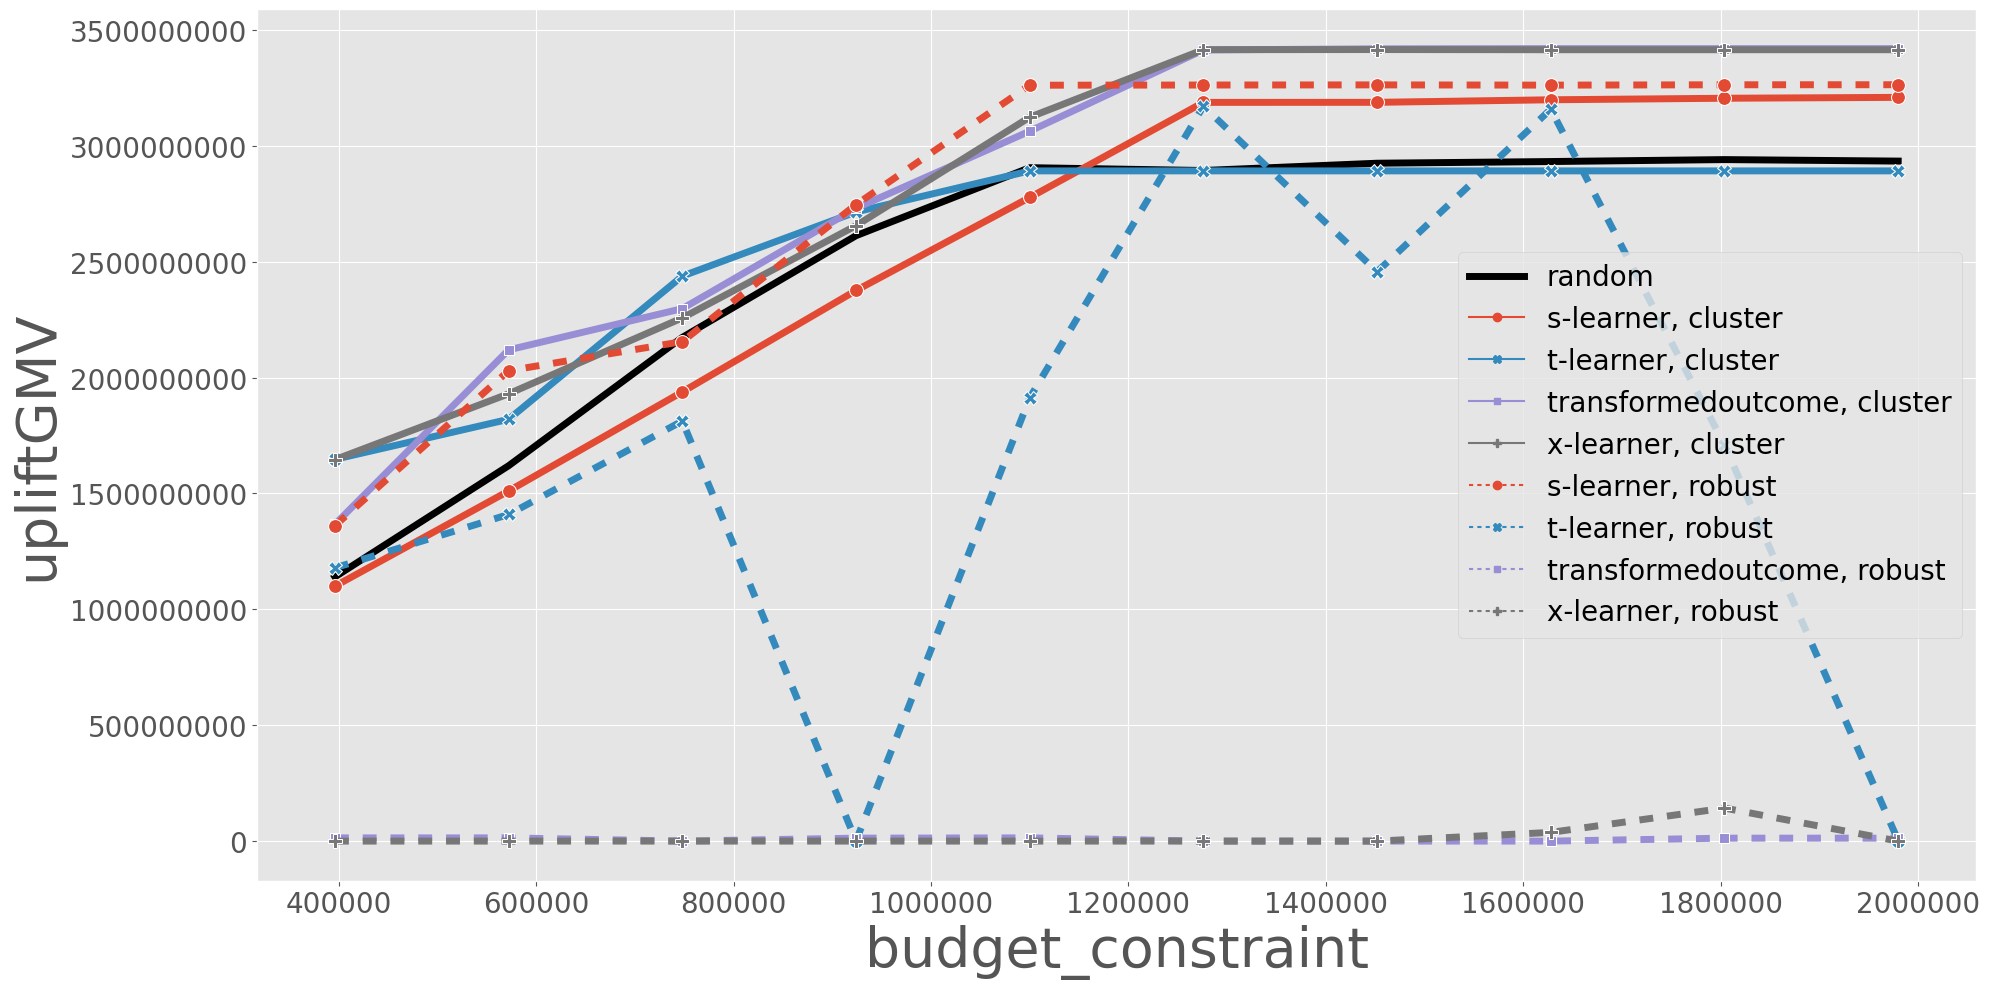

In [29]:
fig, ax = plt.subplots(figsize=(20, 10), tight_layout=True)
linewidth = 5
markersize= 10

ax.plot(
    result_df.query('name == "random"')['budget_constraint'],
    result_df.query('name == "random"')['GMV'],
    label='random',
    color='black',
    linewidth=linewidth,
    markersize=markersize
)
sns.lineplot(data=result_df.query('optimization == "cluster"'), y='GMV', x='budget_constraint', hue='name',
             style='name',
             linewidth=linewidth,
             markersize=markersize,
             markers=True, 
             dashes=False,
             ax=ax)
sns.lineplot(data=result_df.query('optimization == "robust"'), y='GMV', x='budget_constraint', hue='name',
             style='name',
             linestyle='dashed',
             linewidth=linewidth,
             markersize=markersize,
             markers=True, 
             dashes=[(2, 2)] * len(result_df.query('optimization == "robust"')["name"].value_counts()),
             ax=ax)
ax.set_xlabel('budget_constraint', fontsize=40)
ax.set_ylabel('upliftGMV',fontsize=40)
ax.legend(fontsize=20)
ax.set_xticklabels(ax.get_xticks().astype(int), fontsize=20)
ax.set_yticklabels(ax.get_yticks().astype(int), fontsize=20)
fig.savefig(str(eval_dir_config.output_figure_dir / 'upliftGMV.png'))